In [0]:
from time import time
from multiprocessing import cpu_count

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data
from torchvision import datasets, transforms

In [0]:
# GPU configuration
use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

# Load an preprocess MNIST data

In [0]:
# Get MNIST pictures as Torch dataloader
batch_size = 128

mnist = datasets.MNIST('data', train=True, download=True).data.float() / 255
# Perform transformation directly on raw data rather than in the DataLoader
# avoids overhead of transforming at each batch call => much faster epochs.
mnist = transforms.Normalize((0.5,), (0.5,))(mnist)
mnist = mnist.unsqueeze(1)
mnist_dataloader = torch.utils.data.DataLoader(mnist, batch_size=batch_size, shuffle=True)

# Classical GAN

In [0]:
class Generator(nn.Module):
    def __init__(self, input_size, d1, output_shape):
        super(Generator, self).__init__()

        self.map1 = nn.Linear(input_size, d1)
        self.map2 = nn.Linear(self.map1.out_features, d1*2)
        self.map3 = nn.Linear(self.map2.out_features, d1*4)
        self.map4 = nn.Linear(self.map3.out_features, 
                              output_shape[0] * output_shape[1] * output_shape[2])

        self.act = nn.LeakyReLU(negative_slope=0.2)
        self.act_out = nn.Tanh()
        self.output_shape = output_shape

    def forward(self, x):
        x = self.act(self.map1(x))
        x = self.act(self.map2(x))
        x = self.act(self.map3(x))
        x = self.act_out(self.map4(x))
        
        return torch.reshape(x, (-1,)+self.output_shape)

In [0]:
class Discriminator(nn.Module):
    def __init__(self, input_size, d1):
        super(Discriminator, self).__init__()

        self.map1 = nn.Linear(input_size, d1)
        self.map2 = nn.Linear(self.map1.out_features, d1//2)
        self.map3 = nn.Linear(self.map2.out_features, d1//4)
        self.map4 = nn.Linear(self.map3.out_features, 1)

        self.act = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.act(self.map1(x))
        x = F.dropout(x, 0.3)
        x = self.act(self.map2(x))
        x = F.dropout(x, 0.3)
        x = self.act(self.map3(x))
        x = F.dropout(x, 0.3)
        x = torch.sigmoid(self.map4(x))

        return x

In [0]:
class GAN():
    
    def __init__(self, dataloader, gen_params, disc_params, z_dim, lr=0.0001):

        self.dataloader = dataloader

        # default parameters for mnist 
        self.img_channels = dataloader.dataset[0].shape[1]
        self.img_rows = dataloader.dataset[0].shape[2]
        self.img_cols = dataloader.dataset[0].shape[0]
        self.img_shape = (self.img_channels, self.img_rows, self.img_cols)
        self.z_dim = z_dim
        self.lr = lr
        
        self.generator = Generator(*gen_params).to(device)
        self.discriminator = Discriminator(*disc_params).to(device)
        
    def sample_data(self, n_sample=100):
        z_random = np.random.randn(n_sample, self.z_dim)
        z_random = torch.FloatTensor(z_random).to(device)
        samples = self.generator(z_random)
        samples = samples.detach().cpu().numpy()
        return samples
        
    def train(self, epochs=1000, print_interval=1):
        
        criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
        d_optimizer = optim.Adam(self.discriminator.parameters(), lr=self.lr)
        g_optimizer = optim.Adam(self.generator.parameters(), lr=self.lr)
        d_steps = 1
        g_steps = 1
        
        for epoch in range(epochs):
            
            t=time()
            
            for batch in self.dataloader:
                batch = batch.type(torch.FloatTensor).to(device)
                for d_index in range(d_steps):
                    # 1. Train D on real+fake
                    self.discriminator.zero_grad()

                    #  1A: Train D on real
                    d_real_data = Variable(batch.to(device))
                    d_real_decision = self.discriminator(d_real_data)
                    y_real = Variable(torch.ones(d_real_decision.shape).to(device))
                    d_real_error = criterion(d_real_decision, y_real)
        
                    #  1B: Train D on fake
                    d_gen_input = torch.randn((batch.shape[0], self.z_dim))
                    d_gen_input = Variable(d_gen_input.to(device))
                    d_fake_data = self.generator(d_gen_input).detach()  # detach to avoid training G on these labels
                    d_fake_decision = self.discriminator(d_fake_data)
                    y_fake = Variable(torch.zeros(d_real_decision.shape).to(device))
                    d_fake_error = criterion(d_fake_decision, y_fake) 

                    d_train_loss = d_real_error + d_fake_error
                    d_train_loss.backward()
                    d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()
        
                for g_index in range(g_steps):
                    # 2. Train G on D's response (but DO NOT train D on these labels)
                    self.generator.zero_grad()
        
                    gen_input = torch.randn((batch.shape[0], self.z_dim))
                    gen_input = Variable(gen_input.to(device))
                    g_fake_data = self.generator(gen_input)
                    dg_fake_decision = self.discriminator(g_fake_data)
                    y_ones = Variable(torch.ones(dg_fake_decision.shape).to(device))
                    g_error = criterion(dg_fake_decision, y_ones)   # Train G to pretend it's genuine
        
                    g_error.backward()
                    g_optimizer.step()  # Only optimizes G's parameters
                    
    
            if epoch % print_interval == 0:
                de = d_train_loss.detach().cpu().numpy()
                ge = g_error.detach().cpu().numpy()
                print("Epoch %s: D (%s de) G (%s err);  time (%s)" %
                      (epoch, de, ge, time()-t))
                
            if epoch % (print_interval*5) == 0:
                samples = self.sample_data(3)*0.5 + 0.5
                for img in samples:
                    plt.figure()
                    plt.imshow(img[0,:,:], cmap='gray')
                    plt.show()

In [0]:
img_shape = mnist_dataloader.dataset[0].shape
n_pixels = img_shape[0] * img_shape[1] * img_shape[2]

z_dim = 32

gen_params = (z_dim, 128, img_shape)
disc_params = (n_pixels, 1024)

In [0]:
gan = GAN(mnist_dataloader, gen_params, disc_params, z_dim=z_dim, lr=0.0002)

Epoch 0: D (0.9446837 de) G (2.6545045 err);  time (5.064918041229248)


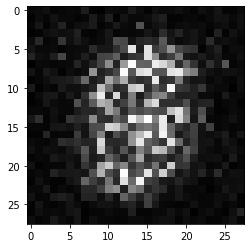

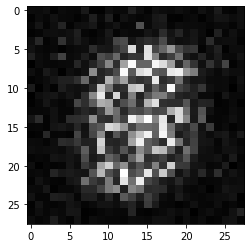

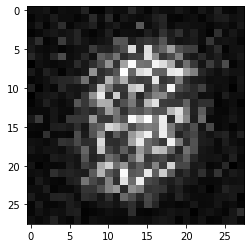

Epoch 1: D (0.8075308 de) G (1.4384727 err);  time (4.927099943161011)
Epoch 2: D (0.078336045 de) G (5.561574 err);  time (5.053927898406982)
Epoch 3: D (0.34678635 de) G (3.2938564 err);  time (5.246053218841553)
Epoch 4: D (0.18379201 de) G (4.4257593 err);  time (4.793697357177734)
Epoch 5: D (0.32599372 de) G (3.4890413 err);  time (5.010738849639893)


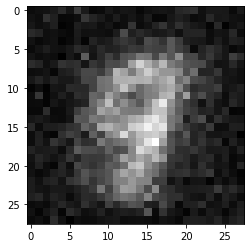

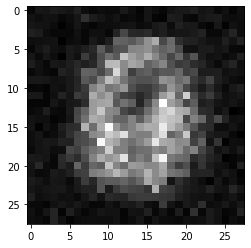

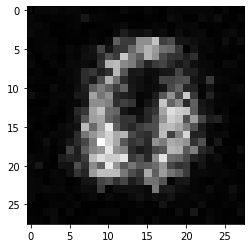

Epoch 6: D (0.6277532 de) G (4.7250857 err);  time (4.935925722122192)
Epoch 7: D (0.2479362 de) G (4.1997046 err);  time (5.082593202590942)
Epoch 8: D (0.17906445 de) G (4.3478384 err);  time (4.821014642715454)
Epoch 9: D (0.38138762 de) G (3.9944434 err);  time (5.569972991943359)
Epoch 10: D (0.27416915 de) G (4.1757975 err);  time (5.21422815322876)


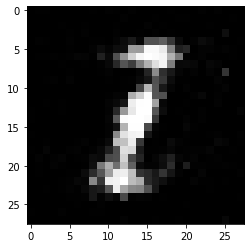

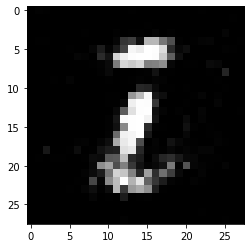

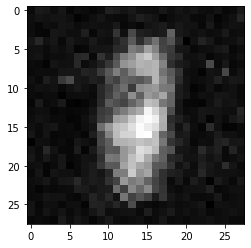

Epoch 11: D (0.14904 de) G (3.2834601 err);  time (5.204302072525024)
Epoch 12: D (0.2076939 de) G (3.8030796 err);  time (4.798442602157593)
Epoch 13: D (0.4231651 de) G (3.687172 err);  time (4.851136922836304)
Epoch 14: D (0.49743238 de) G (3.048678 err);  time (4.84018874168396)
Epoch 15: D (0.40398514 de) G (2.6941624 err);  time (5.055263996124268)


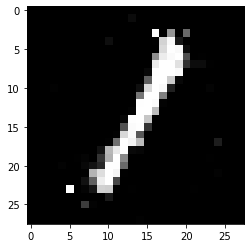

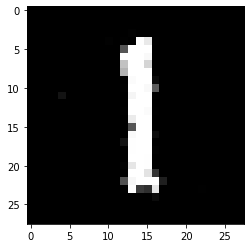

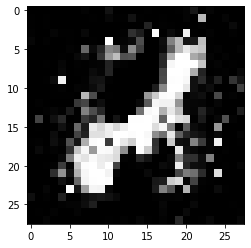

Epoch 16: D (0.5294647 de) G (3.1974287 err);  time (4.786286354064941)
Epoch 17: D (0.42541784 de) G (2.5751653 err);  time (4.845994710922241)
Epoch 18: D (0.6040343 de) G (2.5272074 err);  time (5.088978290557861)
Epoch 19: D (0.49137366 de) G (3.0736575 err);  time (5.0283544063568115)
Epoch 20: D (0.61928016 de) G (2.5205503 err);  time (4.973685026168823)


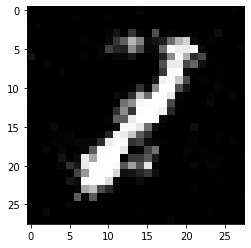

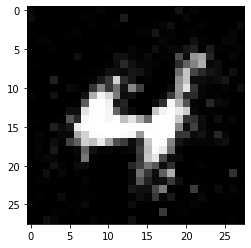

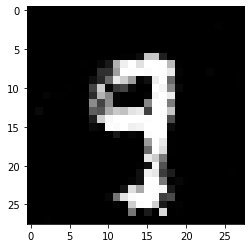

Epoch 21: D (0.50868577 de) G (2.1096275 err);  time (5.719683885574341)
Epoch 22: D (0.5226316 de) G (2.9519424 err);  time (4.962043523788452)
Epoch 23: D (0.4412268 de) G (2.3843625 err);  time (4.843737602233887)
Epoch 24: D (0.5326924 de) G (2.0466905 err);  time (5.389405965805054)
Epoch 25: D (0.6592792 de) G (2.777884 err);  time (4.8866212368011475)


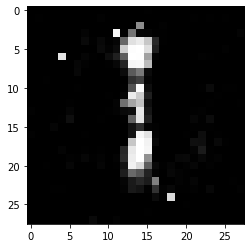

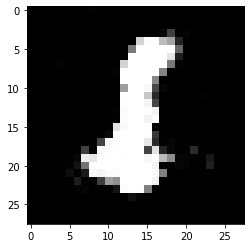

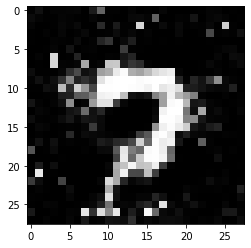

Epoch 26: D (0.6612829 de) G (2.3392274 err);  time (4.813532114028931)
Epoch 27: D (0.77135724 de) G (1.8829187 err);  time (4.918107032775879)
Epoch 28: D (0.48284107 de) G (2.447125 err);  time (4.935904264450073)
Epoch 29: D (0.6312202 de) G (2.2989917 err);  time (5.240782260894775)
Epoch 30: D (0.56363976 de) G (2.8198338 err);  time (5.159600019454956)


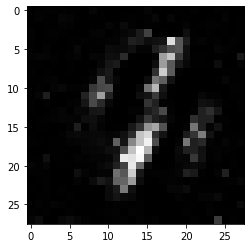

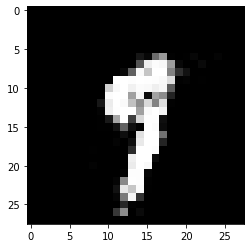

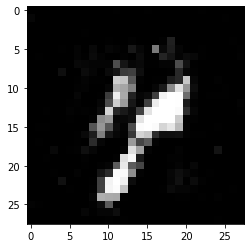

Epoch 31: D (0.59496415 de) G (2.1103969 err);  time (5.059732437133789)
Epoch 32: D (0.65028524 de) G (2.5817347 err);  time (5.081528902053833)
Epoch 33: D (0.54608506 de) G (2.3100617 err);  time (4.77074122428894)
Epoch 34: D (0.62981784 de) G (2.281828 err);  time (4.776062726974487)
Epoch 35: D (0.72453785 de) G (1.8710239 err);  time (4.8833327293396)


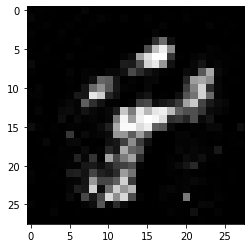

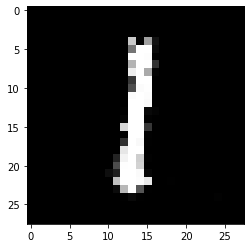

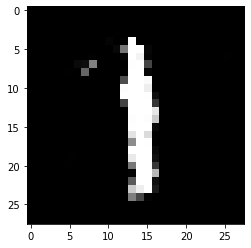

Epoch 36: D (0.76542187 de) G (1.6310128 err);  time (4.787012577056885)
Epoch 37: D (0.9129974 de) G (1.2132368 err);  time (5.231399774551392)
Epoch 38: D (0.89367735 de) G (1.3358881 err);  time (4.872655630111694)
Epoch 39: D (0.64194566 de) G (1.837149 err);  time (4.843480587005615)
Epoch 40: D (0.7091624 de) G (2.242875 err);  time (5.122216463088989)


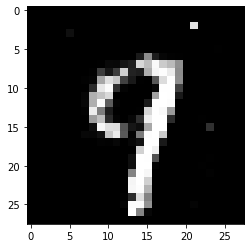

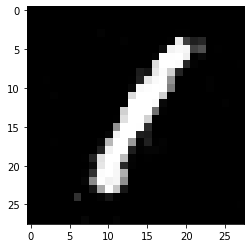

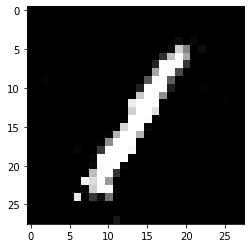

Epoch 41: D (0.85899353 de) G (1.8578339 err);  time (5.523746490478516)
Epoch 42: D (0.8893028 de) G (1.5889318 err);  time (5.213077068328857)
Epoch 43: D (0.9517408 de) G (1.3796415 err);  time (5.07778787612915)
Epoch 44: D (0.95612216 de) G (1.7464457 err);  time (4.859473943710327)
Epoch 45: D (0.7051151 de) G (1.549288 err);  time (4.942253351211548)


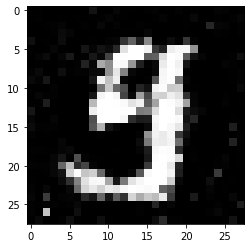

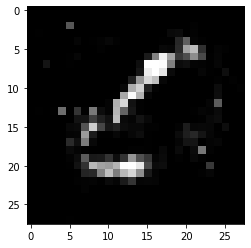

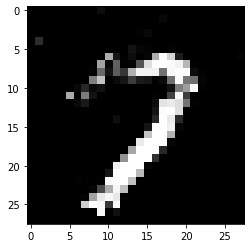

Epoch 46: D (0.75561404 de) G (2.0534706 err);  time (5.264731407165527)
Epoch 47: D (0.9833034 de) G (1.1139464 err);  time (5.068702220916748)
Epoch 48: D (0.81955487 de) G (1.4683464 err);  time (4.8452067375183105)
Epoch 49: D (0.925888 de) G (1.4292629 err);  time (5.0937042236328125)
Epoch 50: D (0.9027714 de) G (1.7373915 err);  time (5.080414056777954)


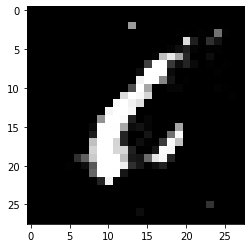

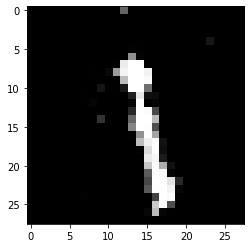

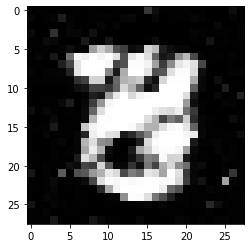

KeyboardInterrupt: ignored

In [182]:
gan.train(200)

In [0]:
samples = gan.sample_data(100)*0.5 + 0.5

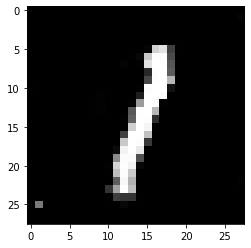

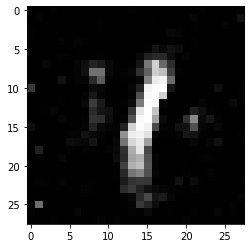

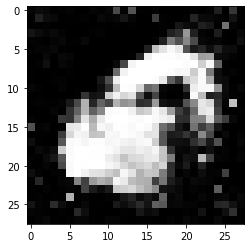

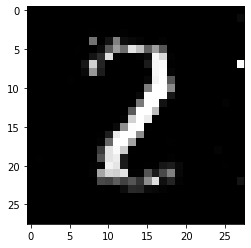

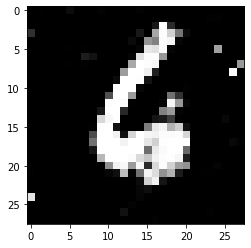

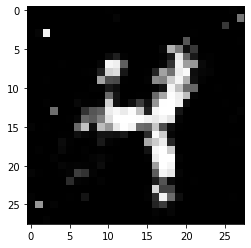

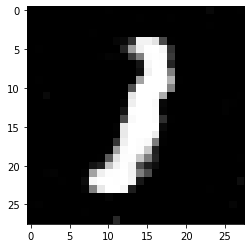

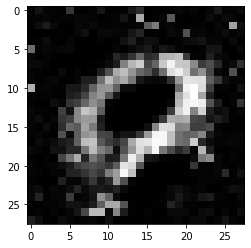

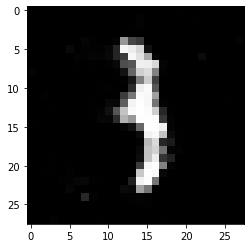

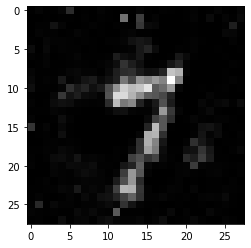

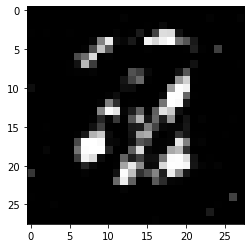

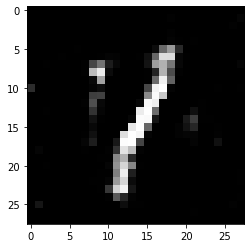

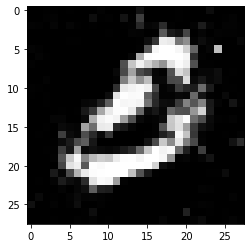

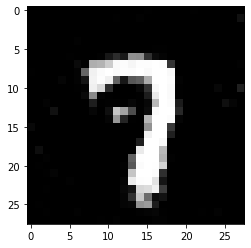

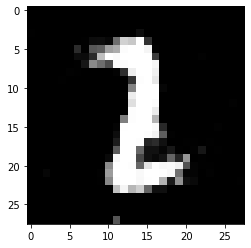

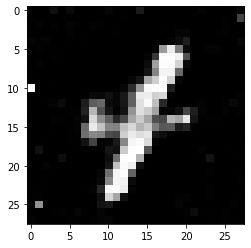

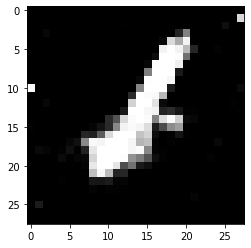

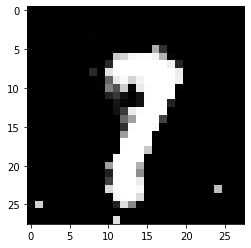

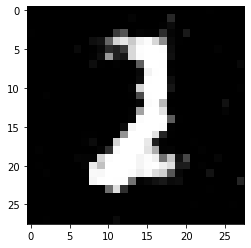

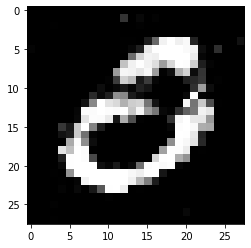

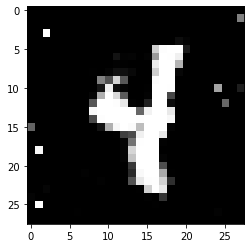

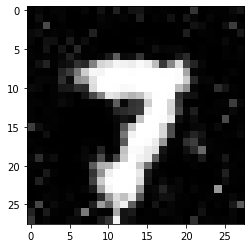

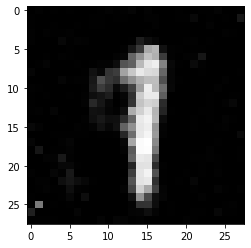

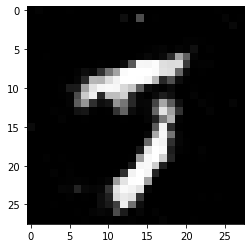

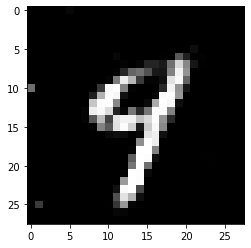

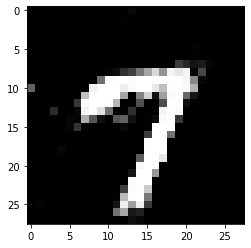

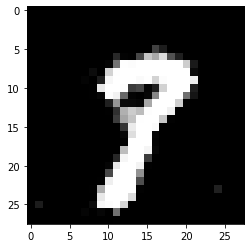

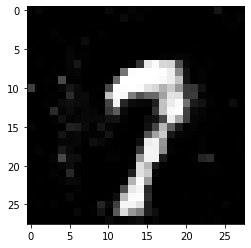

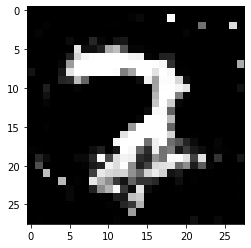

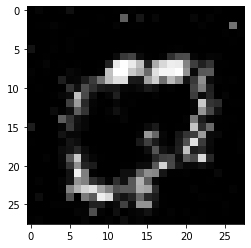

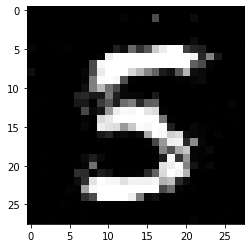

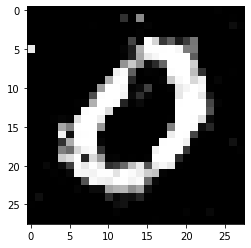

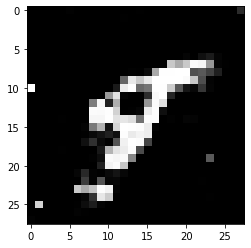

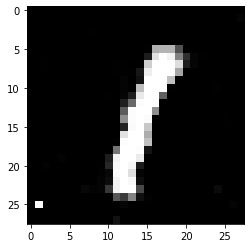

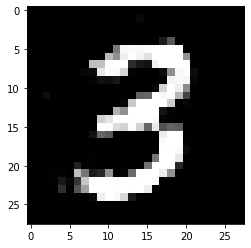

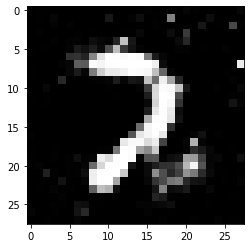

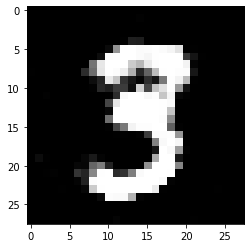

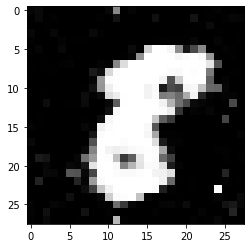

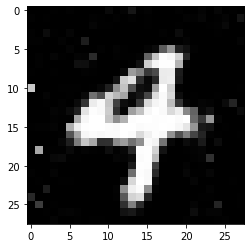

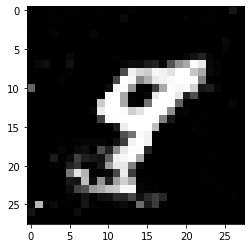

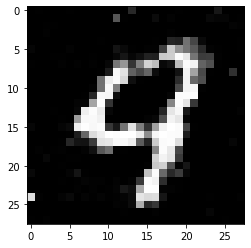

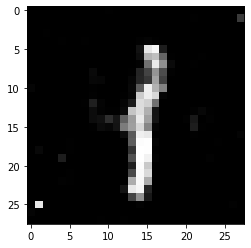

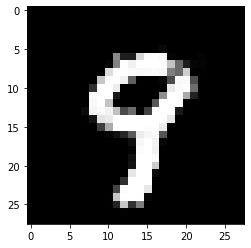

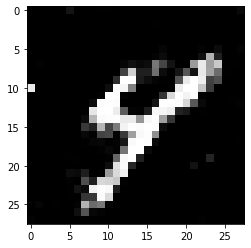

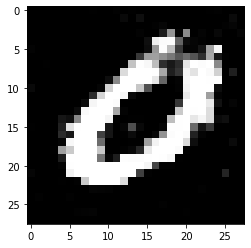

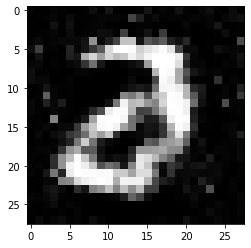

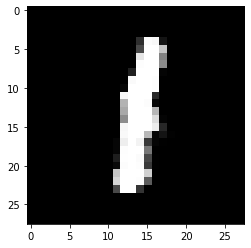

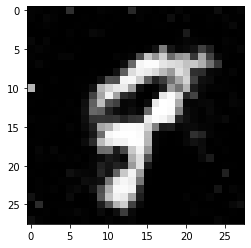

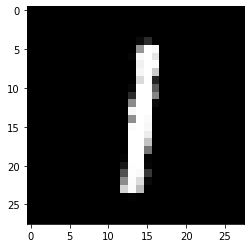

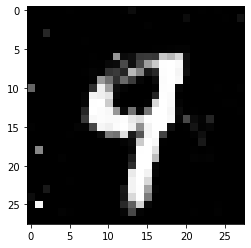

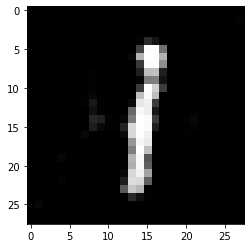

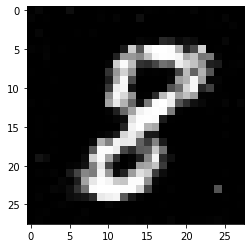

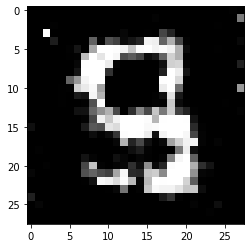

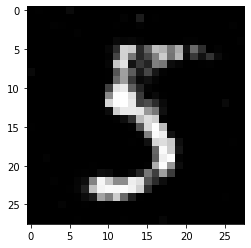

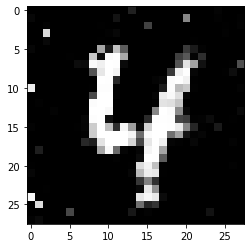

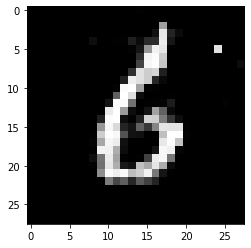

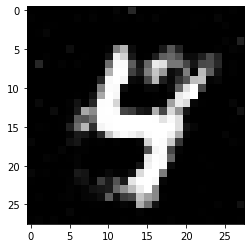

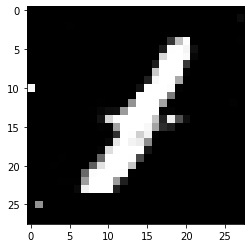

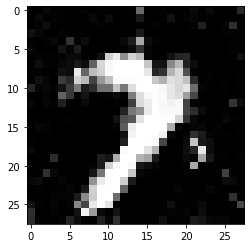

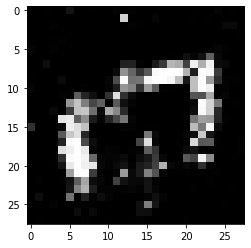

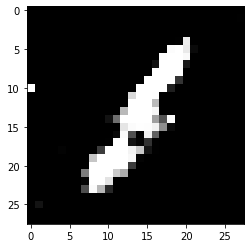

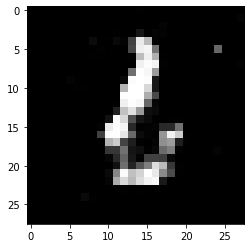

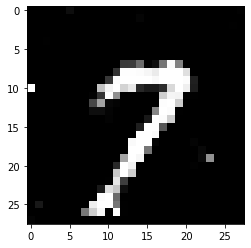

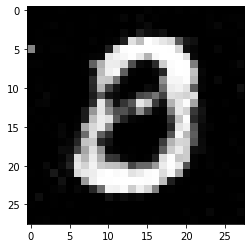

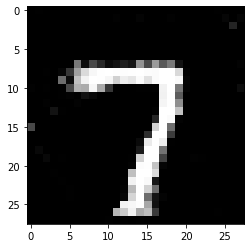

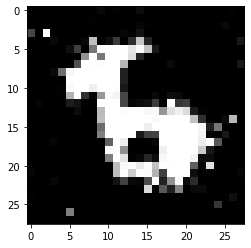

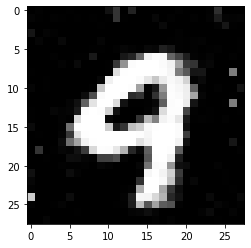

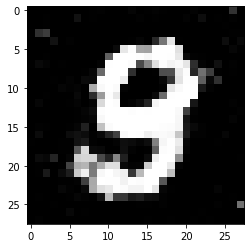

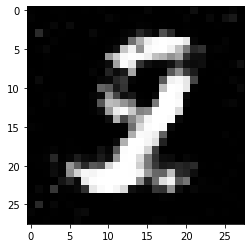

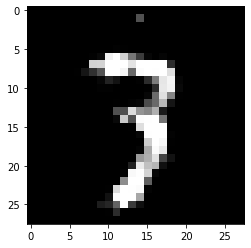

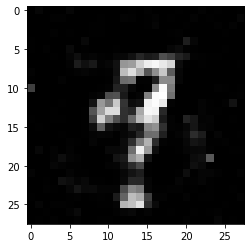

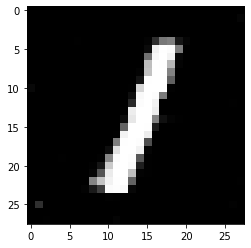

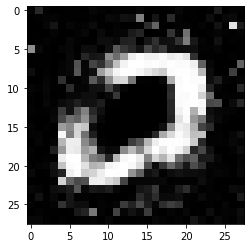

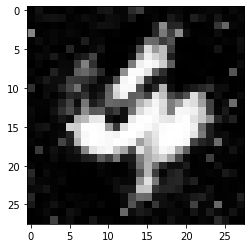

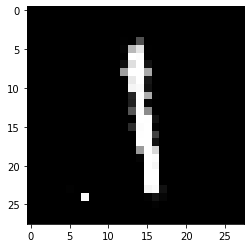

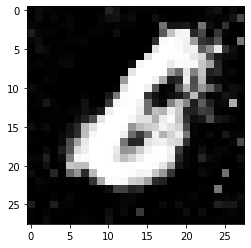

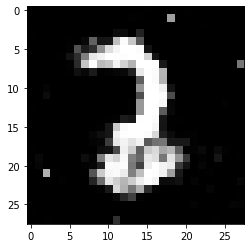

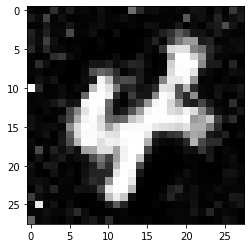

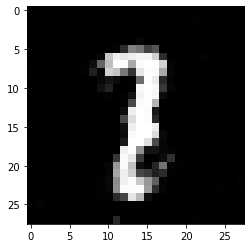

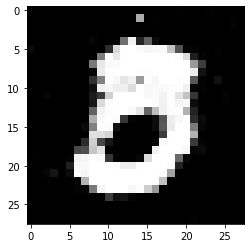

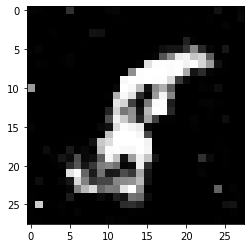

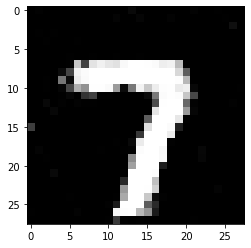

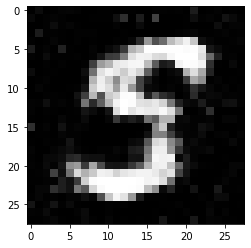

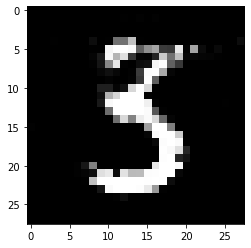

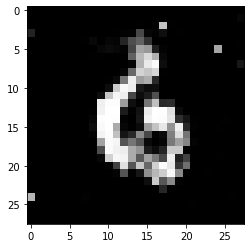

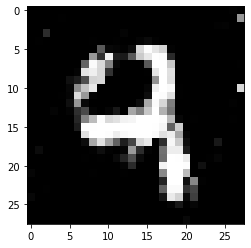

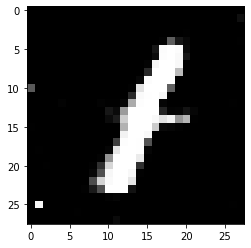

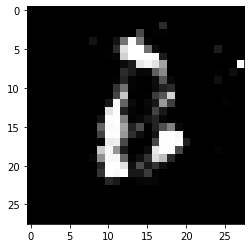

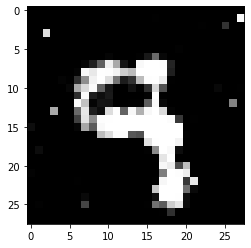

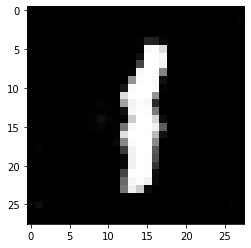

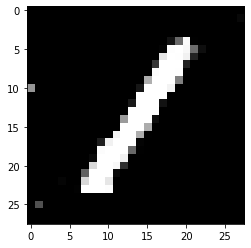

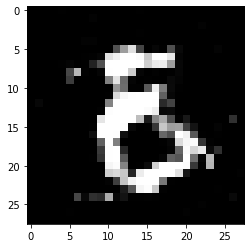

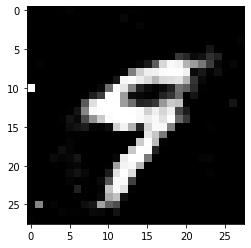

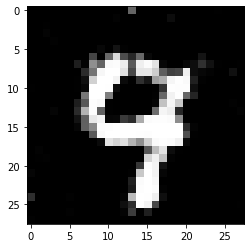

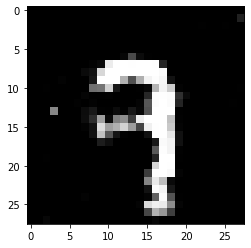

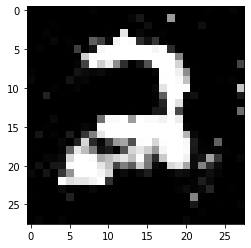

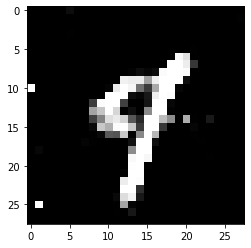

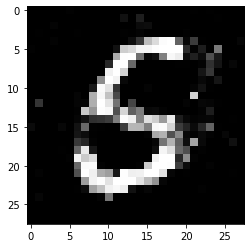

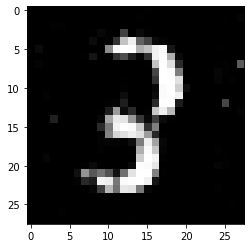

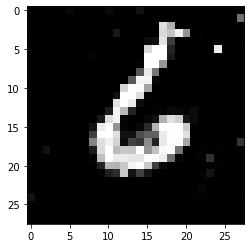

In [185]:
for img in samples:
    plt.figure()
    plt.imshow(img[0,:,:], cmap='gray')
    plt.show()